# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import plot_tree

from sklearn.linear_model import SGDClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report


from scipy import stats

import graphviz 

from utils import plot_decision_boundary
from utils import plot_confusion_matrix

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
dataset

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001



Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

### 1.1

Se refiere a los datos de créditos de consumo y provee 10 variables explicativas de la situación y capacidad de pago de un conjunto de clientes

* __TARGET__: (variable binaria); 1 = préstamo defaulteado - 0 = Préstamo cancelado.
* __LOAN__:    Préstamo requerido ($).
* __MORTDUE__: Deuda restante.
* __VALUE__:   Valor de la propiedad actual.
* __YOJ__:     Años de antiguedad en el trabajo actual.
* __DEROG__:   Número de informes negativos importantes en la escala de créditos (veraz).
* __DELINQ__:  Número de líneas de crédito morosas (más de un mes).
* __CLAGE__:   Antigüedad del último reporte de actividad crediticia mensual(score, ..).
* __NINQ__:    Número de líneas de crédito actuales.
* __CLNO__:    Número de líneas de crédito.
* __DEBTINC__: Ratio deuda-ingreso.

***

### 1.2

La variable a predecir es __'TARGET'__ y significa si el cliente va a defaultear o no. En el primer caso (TARGET=1) no habría que concederle el crédito. En el segundo caso(TARGET=0), se le puede ofrecer un crédito o ampliar la línea crediticia.

***

### 1.3
Hay muchas variables explicativas del comportamiento crediticio de una persona. El nivel de deuda solicitado y el ratio deuda - ingreso son importantes al momento de evaluar la capacidad de generar flujos de pago. El valor de la propiedad actual también es importante porque refleja la garantía del crédito. La rotación laboral indica que si se ha mantenido en el trabajo actual mucho tiempo es posible que no sea despedido y eso posibilite el pago de la deuda a contraer. La historia crediticia, ya sea
por atrasos mayores a un mes en los pagos con sus implicancias en el veraz (DEROG) son importantes a la hora de explicar la aptitud de pago.

***

### 1.4 
Intuitivamente podríamos decir que al considerar el score crediticio los atributos de mayor importancia son el monto del crédito, la sobrecarga de deudas (reflejada por el ratio deuda -ingreso) y la historia crediticia (reflejada por DEROG y DELINQ). La actividad de continua refinanciación refleja un cliente potencialmente problemático, de allí que CLAGE tambíen será importante. El tamaño de la deuda y activos parece tener poca relación con la posibilidad de default, esto puede ser porque al principio son importantes, pero luego la historia crediticia tiene más fuerza. Los activos son solo importantes al final, cuando el crédito es irrecuperable. Cuando ya se ha tomado la deuda, las refinanciaciones son primero una opción, de allí que la historia crediticia prima.

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

### 2.1

In [4]:
model = SGDClassifier(random_state=0)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1232
           1       0.00      0.00      0.00       251

    accuracy                           0.83      1483
   macro avg       0.42      0.50      0.45      1483
weighted avg       0.69      0.83      0.75      1483
 
 None


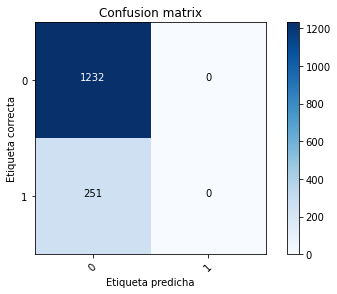

In [5]:
# Entrenamiento
cm_train = confusion_matrix(y_train, y_train_pred)
tr_plot = plot_confusion_matrix(cm_train, [0,1])
print(classification_report(y_train, y_train_pred,zero_division=0),'\n',tr_plot)

              precision    recall  f1-score   support

           0       0.84      1.00      0.92       313
           1       0.00      0.00      0.00        58

    accuracy                           0.84       371
   macro avg       0.42      0.50      0.46       371
weighted avg       0.71      0.84      0.77       371
 
 None


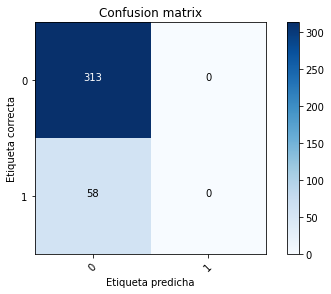

In [6]:
# Evaluación
cm_test = confusion_matrix(y_test, y_test_pred)
test_plot = plot_confusion_matrix(cm_test, [0,1])
print(classification_report(y_test, y_test_pred,zero_division=0),'\n',test_plot)

***

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

### 2.2

In [34]:
clf = GridSearchCV(SGDClassifier(eta0=0.1,random_state=0),{'loss':['hinge', 'log', 
                                                                   'modified_huber', 
                                                                   'squared_hinge', 'perceptron'],
                                    'penalty':['l2', 'l1', 'elasticnet'],
                                    'learning_rate':['constant', 'optimal', 
                                                     'invscaling', 'adaptive']},cv=5)

clf.fit(X_train, y_train)
clf.cv_results_

results = pd.DataFrame(clf.cv_results_)
results.loc[:,'variance_test_score'] = (results.std_test_score.values)**2                                              
report = results[['param_loss','param_penalty',
                  'param_learning_rate','mean_test_score',
                  'variance_test_score']].sort_values('mean_test_score',ascending=False)
#report

In [36]:
print(clf.best_params_,'\n',clf.best_score_)
#dir(clf)

{'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'} 
 0.8307489307489307


In [37]:
# Mejor modelo
best_model = SGDClassifier(random_state=0, learning_rate='optimal',loss='hinge',penalty='l2')
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1232
           1       0.00      0.00      0.00       251

    accuracy                           0.83      1483
   macro avg       0.42      0.50      0.45      1483
weighted avg       0.69      0.83      0.75      1483
 
 None


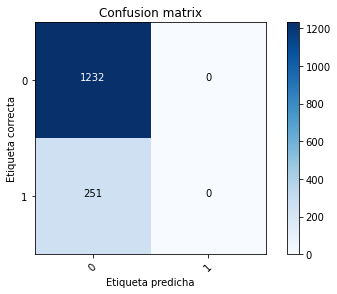

In [38]:
# Entrenamiento
cm_train = confusion_matrix(y_train, y_train_pred)
tr_plot = plot_confusion_matrix(cm_train, [0,1])
print(classification_report(y_train, y_train_pred,zero_division=0),'\n',tr_plot)

              precision    recall  f1-score   support

           0       0.84      1.00      0.92       313
           1       0.00      0.00      0.00        58

    accuracy                           0.84       371
   macro avg       0.42      0.50      0.46       371
weighted avg       0.71      0.84      0.77       371
 
 None


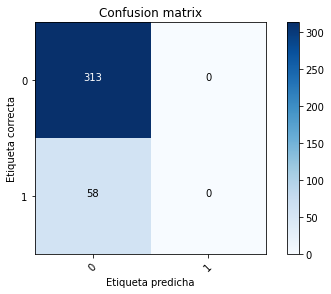

In [39]:
# Evaluación
cm_test = confusion_matrix(y_test, y_test_pred)
test_plot = plot_confusion_matrix(cm_test, [0,1])
print(classification_report(y_test, y_test_pred,zero_division=0),'\n',test_plot)

***

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


### 3.1

In [40]:
clt = DecisionTreeClassifier(random_state=0)
clt.fit(X_train, y_train)

# Predicción y evaluación
y_train_pred = clt.predict(X_train)
y_test_pred = clt.predict(X_test)
#tree.plot_tree(clt)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483
 
 None


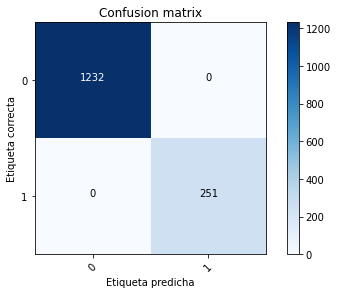

In [41]:
# Entrenamiento
cm_train = confusion_matrix(y_train, y_train_pred)
tr_plot = plot_confusion_matrix(cm_train, [0,1])
print(classification_report(y_train, y_train_pred,zero_division=0),'\n',tr_plot)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371
 
 None


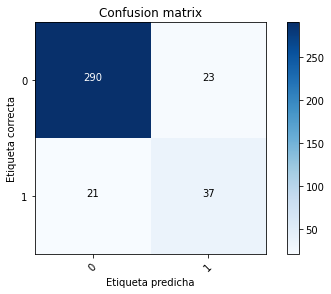

In [42]:
# Evaluación
cm_test = confusion_matrix(y_test, y_test_pred)
test_plot = plot_confusion_matrix(cm_test, [0,1])
print(classification_report(y_test, y_test_pred,zero_division=0),'\n',test_plot)

***

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

### 3.2

In [45]:
cl_tree = GridSearchCV(DecisionTreeClassifier(random_state=0),{'criterion':['gini', 'entropy'],
                                                  'max_depth':[1,2,3,4,5,None],
                                                  'min_samples_leaf':[1,2,3,4,5]},cv=5)

cl_tree.fit(X_train, y_train)
cl_tree.cv_results_

results_tr = pd.DataFrame(cl_tree.cv_results_)
results_tr.loc[:,'variance_test_score'] = (results_tr.std_test_score.values)**2                                              
report_tr = results_tr[['param_criterion','param_max_depth',
                        'param_min_samples_leaf' ,'mean_test_score',
                        'variance_test_score']].sort_values('mean_test_score',ascending=False)
#report_tr

In [46]:
print(cl_tree.best_params_,'\n',cl_tree.best_score_)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3} 
 0.8799777049777051


In [47]:
# Mejor modelo
bm_tr = DecisionTreeClassifier(random_state=0, criterion='gini',max_depth=4,min_samples_leaf=3)
bm_tr.fit(X_train, y_train)
y_train_pred = bm_tr.predict(X_train)
y_test_pred = bm_tr.predict(X_test)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1232
           1       0.92      0.42      0.58       251

    accuracy                           0.90      1483
   macro avg       0.91      0.71      0.76      1483
weighted avg       0.90      0.90      0.88      1483
 
 None


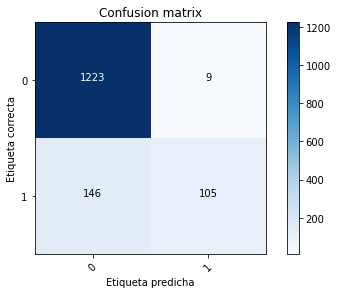

In [48]:
# Entrenamiento
cm_train = confusion_matrix(y_train, y_train_pred)
tr_plot = plot_confusion_matrix(cm_train, [0,1])
print(classification_report(y_train, y_train_pred,zero_division=0),'\n',tr_plot)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       313
           1       0.73      0.38      0.50        58

    accuracy                           0.88       371
   macro avg       0.81      0.68      0.72       371
weighted avg       0.87      0.88      0.87       371
 
 None


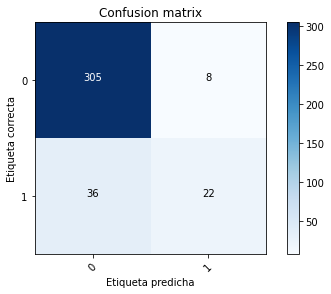

In [49]:
# Evaluación
cm_test = confusion_matrix(y_test, y_test_pred)
test_plot = plot_confusion_matrix(cm_test, [0,1])
print(classification_report(y_test, y_test_pred,zero_division=0),'\n',test_plot)

***